## LLM

In [1]:
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from src.tokenizer import TokenizerBPE, fuse_tokenized_corpus, chunk_corpus

import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import numpy as np
import pickle as pkl
from tqdm.notebook import tqdm
from src.transformer import *
from src.data_handling import split_on_value



print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tf.keras.mixed_precision.set_global_policy('mixed_float16')

Num GPUs Available:  1
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 SUPER, compute capability 7.5


In [2]:
tokenizer = pkl.load(open("tokenizer_QA8000.pkl", 'rb'))
tokenizer.add_special_tokens(["<pad>"])

value = tokenizer.token_to_idx["<s>"]
corpus = pkl.load(open('corpus/QA_8k.pkl', 'rb'))[0]

corpus_list = split_on_value(corpus, value)
random.shuffle(corpus_list)
train_list = corpus_list[:int(len(corpus_list)*0.90)]
test_list = corpus_list[int(len(corpus_list)*0.90):]

In [3]:
print(len(train_list), len(test_list))

78138 8683


In [4]:
max_seq_len = 64

output_signature = tf.TensorSpec(shape=(None,), dtype=tf.int32)

train = iter(train_list)
test = iter(test_list)

def truncate(seq):
    return seq[:max_seq_len]

value = tokenizer.token_to_idx["<pad>"]

ds_train = tf.data.Dataset.from_generator(
    lambda: iter(train_list),         # ← returns a brand-new iterator each epoch
    output_signature=output_signature
).map(truncate) \
 .padded_batch(32, padded_shapes=[max_seq_len], padding_values=value) \
 .repeat()   # now truly infinite

ds_test = tf.data.Dataset.from_generator(
    lambda: iter(test_list),         # ← returns a brand-new iterator each epoch
    output_signature=output_signature
).map(truncate) \
 .padded_batch(8, padded_shapes=[max_seq_len], padding_values=value) \
 .repeat()   # now truly infinite

## Define Model

In [5]:
initial_lr = 1e-4
decay_steps = 20000
decay_rate = 0.5
decay_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=False)

warmup_steps = 1000
lr_schedule = WarmUpThenDecay(
    initial_learning_rate=initial_lr,
    warmup_steps=warmup_steps,
    decay_schedule_fn=decay_schedule)

np.random.seed(42)
tf.random.set_seed(42)

embed_dim = 700
tf_blocks = 10
heads = 10
ff_dim = 4*embed_dim
weight_decay = 0.01
dropout = 0.1

unembed_dims = []

model = Transformer(vocab_size=tokenizer.vocab_size,
                    max_seq_len=max_seq_len,
                    embed_dim=embed_dim,
                    tf_blocks=tf_blocks,
                    heads=heads,
                    ff_dim = ff_dim,
                    unembed_dims=unembed_dims,
                    tokenizer=tokenizer,
                    lr=lr_schedule,
                    wd = weight_decay,
                    dropout=dropout,
                    )

losses_train = []
losses_test = []


In [6]:
name = "model_qa_8k_padding"

ckpt = tf.train.Checkpoint(
    optimizer=model.opt,
    model=model
)
ckpt_manager = tf.train.CheckpointManager(
    ckpt, 
    directory="checkpoints/" + name,      # folder where ckpts are saved
    max_to_keep=5                         # only keep 5 latest checkpoints
)

In [6]:
ckpt.restore(ckpt_manager.latest_checkpoint)
losses_train, losses_test = pkl.load(open("checkpoints/losses_" + name + ".pkl", 'rb'))

In [7]:
total_params = 0
for var in model.parameter_list:
    shape = var.get_shape()
    num_params = 1
    for dim in shape:
        num_params *= dim
    total_params += num_params
print(f"Total number of parameters: {total_params}")

Total number of parameters: 64754140


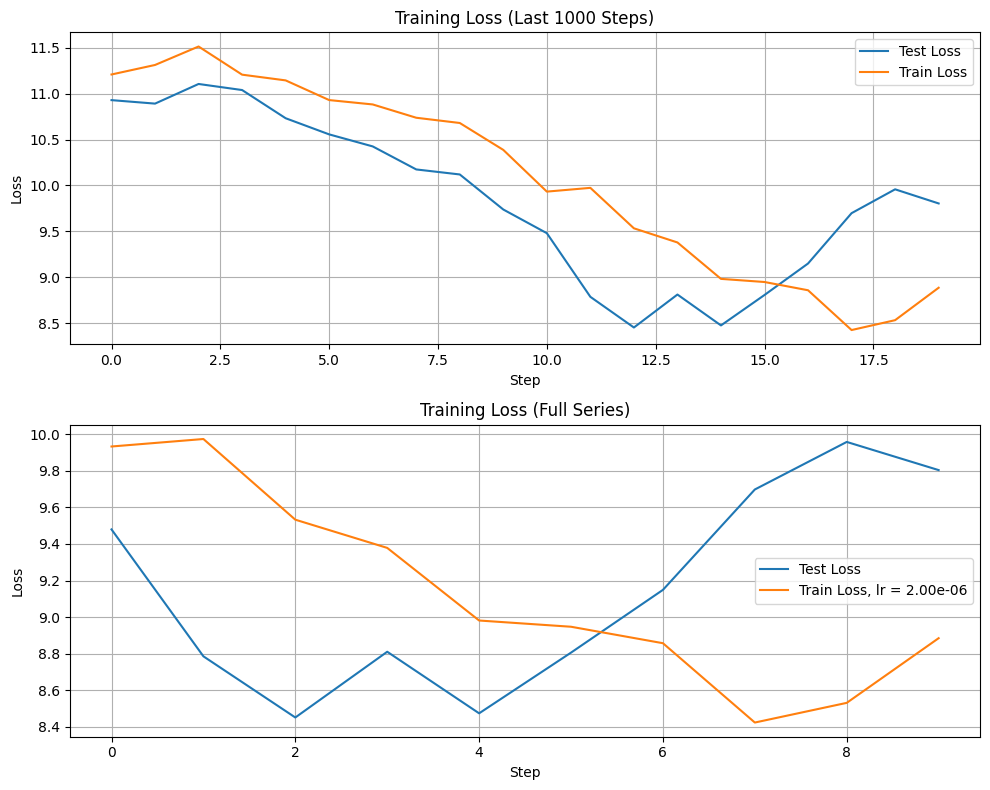

(32, 64)


KeyboardInterrupt: 

In [8]:
for i, (batch_train, batch_test) in enumerate(zip(ds_train, ds_test)):
    print(batch_train.shape)

    loss_train = model.train_step(batch_train).numpy()
    losses_train.append(loss_train)
    
    loss_test = model.evaluate(batch_test).numpy()
    losses_test.append(loss_test)

    if (i+1) % 1000 == 0:
        ckpt_manager.save()
        pkl.dump([losses_train, losses_test], open("checkpoints/losses_" + name + ".pkl", 'wb'))


    lr = model.opt.inner_optimizer._decayed_lr(tf.float32).numpy()
    
    clear_output(wait=True)

    # prepare x-axis for the last 400 steps
    start = max(0, len(losses_train) - 1000)
    x_zoom = np.arange(start, len(losses_train))

    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

    # Top subplot: zoom on last 400 steps
    ax1 = axes[0]
    ax1.plot(x_zoom, losses_test[-1000:], label="Test Loss")
    ax1.plot(x_zoom, losses_train[-1000:], label="Train Loss")

    _min = min(losses_train[-1000:] + losses_test[-1000:])
    _max = max(losses_train[-1000:] + losses_test[-1000:])
    delta = _max - _min
    #ax1.set_ylim(_min - 0.1 * delta, _max + 0.1 * delta)

    ax1.set_title("Training Loss (Last 1000 Steps)")
    ax1.set_xlabel("Step")
    ax1.set_ylabel("Loss")
    ax1.legend()
    ax1.grid(True)

    # Bottom subplot: full series
    ax2 = axes[1]
    ax2.plot(losses_test[10:], label="Test Loss")
    ax2.plot(losses_train[10:], label="Train Loss, lr = {:.2e}".format(lr))

    ax2.set_title("Training Loss (Full Series)")
    ax2.set_xlabel("Step")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()
    

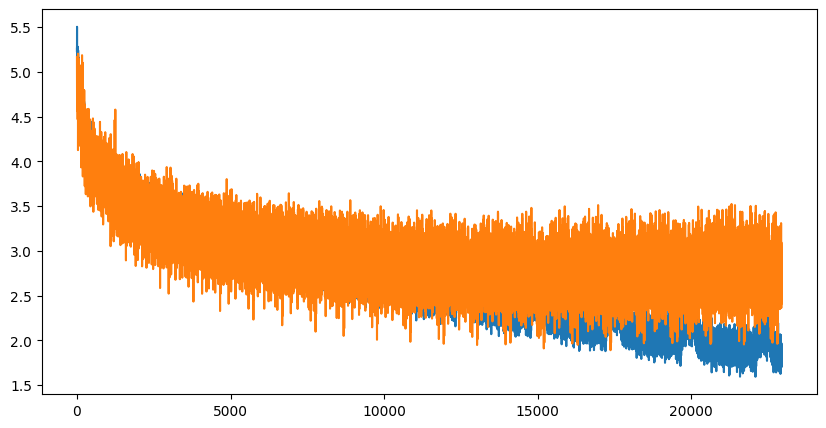

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(losses_train[100:], label="Train Loss")
plt.plot(losses_test[100:], label="Test Loss")

In [11]:
text = ""
text = text.lower()
sos = tf.convert_to_tensor([[tokenizer.token_to_idx["<s>"]]])
q = tf.convert_to_tensor([[tokenizer.token_to_idx["<q>"]]])
indices = tf.cast(tokenizer.encode(text), tf.int32)
indices = tf.concat([sos, q, indices], axis=1)
print(indices)


import textwrap
import ipywidgets as widgets
from IPython.display import display

T = 0.5
#tf.random.set_seed(43)
wrapper = textwrap.TextWrapper(width=80)

# create a read-only text area
ta = widgets.Textarea(
    value="",
    layout=widgets.Layout(width='80ch', height='20em'),
    disabled=True
)
display(ta)

for i in range(512):
    logits = model.call(indices)[0, -1:]
    idx = tf.cast(
        tf.random.categorical(logits / T, num_samples=1),
        tf.int32
    )
    indices = tf.concat([indices, idx], axis=1)

    text_pred = (
        tokenizer
        .decode(indices)
        .numpy()[0]
        .decode('utf-8')
        .replace("\n", " ")
    )
    ta.value = wrapper.fill(text_pred)  # this updates in-place

    if idx[0, 0] == tokenizer.token_to_idx["</s>"]:
        break

tf.Tensor([[8335 8337]], shape=(1, 2), dtype=int32)


Textarea(value='', disabled=True, layout=Layout(height='20em', width='80ch'))

In [12]:
from sklearn.cluster import KMeans

def cosine_similarity(embed_a, embed_b):
    """
    Compute the cosine similarity between two vectors.
    """
    embed_b_T = tf.transpose(embed_b)
    dot_product = embed_a@embed_b_T
    
    norm_a = tf.linalg.norm(embed_a, axis=1, keepdims=True)
    norm_b = tf.linalg.norm(embed_b_T, axis=0, keepdims=True)

    return dot_product / (norm_a * norm_b)


def cluster(X, n_clusters, normalize=True):
    if normalize:
        X = X/np.linalg.norm(X, axis=1, keepdims=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    inertia = kmeans.inertia_
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_

    return inertia, labels, clusters


class EmbeddingClustering:
    def __init__(self, tokenizer, n_clusters=10):
        
        self.tokenizer = tokenizer
        self.n_clusters = n_clusters

    def fit(self, word_embed, normalize=True):
        inertia, labels, clusters = cluster(word_embed, self.n_clusters, normalize)
        self.word_embed = word_embed
        self.inertia = inertia
        self.labels = labels
        self.clusters = tf.convert_to_tensor(clusters, dtype=tf.float32)

        cos_sim = cosine_similarity(self.clusters, word_embed, normalize)
        self.idx_list =  tf.argsort(cos_sim, axis=-1, direction='DESCENDING', stable=False, name=None)

    def print_clusters(self, n_words=10):
        for idx in self.idx_list:
            for i in idx[:n_words]:
                word = self.tokenizer.decode(tf.expand_dims(tf.cast(i, tf.int32), axis=0))
                word = word.numpy().decode('utf-8')
                print(word)
            print("\n")


def cosine_similarity(embed_a, embed_b, normalize=True):
    """
    Compute the cosine similarity between two vectors.
    """
    if normalize:
        embed_a = tf.nn.l2_normalize(embed_a, axis=1)
        embed_b = tf.nn.l2_normalize(embed_b, axis=1)
    dot_product = embed_a@tf.transpose(embed_b)


    return dot_product

In [13]:
word_embed = model.word_embed
embedding_clustering = EmbeddingClustering(tokenizer, n_clusters=100)
embedding_clustering.fit(word_embed, normalize=True)
embedding_clustering.print_clusters(n_words=10)

chos
yang
buddhist
qing
han
ich
ved
plate
za
ta


desk
lican
@
doct
okla
yugo
byter
arct
docu
zenegger


balkans
figh
usalem
frederic's
capit
@
termine
taceous
ennas
mosc


β
isra
@
figh
headquar
vot
indigen
taceous
瑚
ashire


figh
febr
@
desk
arct
headquar
satell
petrole
indigen
usalem


gab
plat
nap
cruci
dep
pom
alum
mol
mandol
flu


@
̇
ố
taceous
isra
瑚
coln
baro
imum
octo


choose
refuse
want
decide
attempt
try
arrive
send
extend
appoint


western
southern
eastern
european
new
regional
northern
north
national
medieval


petrole
icode
whitney
lican
eign
ingre
targe
zt
hower
в


predat
vot
uset
gorith
veh
headquar
newspa
techni
otle
nuc


acu
gorith
lican
guay
zt
ingre
mandu
vot
eign
tware


1936
1959
1986
2004
1952
1968
1945
lican
1946
1918


libr
director
parade
secretary
minister
library
diction
memorial
editor
profess


partners
policing
investigation
centers
movies
divisions
resources
authority
teams
infrastructure


leds
lical
perior
filament
onsored
petrole
indigen
mandu
roos

# Overlap

In [ ]:
word_embed = model.word_embed

text = "russia"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed1 = tf.expand_dims(word_embed[idx[0][0]], axis=0)


text = "putin"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed2 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

text = "netanyahu"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed3 = tf.expand_dims(word_embed[idx[0][0]], axis=0)

embed = embed1 - embed2 + embed3

cosine_sim = cosine_similarity(embed, word_embed, normalize=False)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[1602]], shape=(1, 1), dtype=int32)
tf.Tensor([[3512]], shape=(1, 1), dtype=int32)
tf.Tensor([[5393]], shape=(1, 1), dtype=int32)
netanyahu
russia
israel
hamas
israelis
jerusalem
tehran
kiev
gaza
palestinians
democr
beirut
azer
syria
egypt
idf
iran
britain
palestinian
abbas
tunisia
alger
lebanon
perpe
israeli
davos
brahim
controver
hezbollah
hagel
jevich
norway
fah
guinea
khamenei
cuba
anbar
utt
khamene
hezbol
weren
canada
sunnis
dipl
stoke
lavrov
aviv
karzai
israel's
arct
cambodia
zuckerberg
yanukov
yad
ukraine
pakistan
carney
netherlands
cairo
lieberman
panetta
homs
zawah
austria
espion
wawrink
vinc
libertar
libya
poland
indonesia
liby
merkel
pyongyang
tik
airstrikes
ibrahimovic
abe
iran's
yugo
kass
mosul
galax
yemen
scotland
settlements
sudan
nuri
niger
palestine
tsvangira
ieval
iaea
denmark
hmer
tahrir
nusra
sarkoz
ukrain
bolivia


In [ ]:
word_embed = model.word_embed

text = "obama"
text = text.lower()

idx = tf.cast(tokenizer.tokenize(text), tf.int32)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[553]], shape=(1, 1), dtype=int32)
obama
obama's
clinton
romney
republicans
bush
boehner
sen
reagan
democrats
barack
mccain
congressional
sarkozy
pentagon
putin
u
assad
liberals
afghans
calderon
washington
bush's
conservatives
president
obamacare
iraqis
panetta
snowden
mcconnell
clinton's
chavez
gop
palin
americans
senate
christie
isis
veterans
he
voters
petraeus
pelosi
secretary
jindal
george
mandela
republican
kerry
karzai
biden
gop's
francis
economists
lawmakers
jeb
we've
congressman
rouhani
navarrette
congress
netanyahu
latinos
nixon
aides
iraqi
nra
pelos
richard
white
clint
gov
lincoln
romney's
gingrich
taxpayers
nato
presidents
vietnam
nieto
analysts
president's
ryan
gupta
senators
cdc
shinse
brennan
next
capitol
legislators
ahmadinejad
elect
erdogan
afghanistan
iraq
gadhafi
roosevelt
cheney
santorum


In [ ]:
word_embed = model.word_embed

text = "netanyahu"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
embed = tf.expand_dims(word_embed[idx[0][0]], axis=0)

cosine_sim = embed@tf.transpose(word_embed)
idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))

tf.Tensor([[5393]], shape=(1, 1), dtype=int32)
netanyahu
abulary
hagel
maduro
espion
yingluck
onsored
nandez
saleh
natur
ailand
hezbol
panetta
biden
shinse
kerry
gibbs
sarkozy
fundam
hift
patro
signific
anonymity
putin
mugabe
lades
boehner
pelosi
medvedev
ahmadinejad
warri
thaksin
landrieu
shaba
gbag
accust
charac
fahren
liby
peninsu
helicop
zuma
traged
portugu
morsy
publ
enjo
ilight
abbas
erdogan
ieval
bachmann
yanukovych
leep
confir
rodrigue
secutive
provin
mccain's
moil
subsequ
abled
juvent
o'ne
guardiola
lieberman
karzai
catastro
ouatt
zardari
possib
toug
theless
burma
carney
ricul
zhok
barcelon
dort
sunnis
lomb
snowden
avez
diffic
sess
khamenei
exer
golese
copen
rouhani
ipal
transparen
ultane
mccain
boeh
diox
citiz
adjac
nieto
lavrov


## Mean Pooling

In [ ]:
word_embed = model.word_embed

text = "Obama's remarks came shortly after U.N. inspectors left Syria, carrying evidence that will determine whether chemical weapons were used in an attack early last week in a Damascus suburb."
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx.shape)
embed_final = model.call(idx, logits=False)
#embed_mean = embed_final[:,-1,:]
embed_mean = tf.reduce_mean(embed_final, axis=1)
embed_mean = tf.cast(embed_mean, dtype=tf.float32) 

cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=False)
#cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=True)

idx = tf.argsort(cosine_sim, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))


(1, 62)
 
.
-
"
,
a
in


and
the
on
to
at
'
an
or
u
by
that
:
as
's
s
al
of
it
he
for
un
over
e
about
is
with
after
up
not
last
more
may
?
re
from
ad
(
state
be
just
so
was
one
/
ed
no
war
while
security
;
but
1
en
n
man
house
i
north
m
first
ar
l
f
c
er
there
out
o
do
two
when
less
had
air
k
v
h
near
they
2
his
some
de
back
we
field
fire
if
this
under
p
right


In [ ]:
word_embed = model.word_embed

text = "Obama"
text = text.lower()

idx = tf.cast(tokenizer.tokenizer.tokenize(text), tf.int32)
idx = tokenize(idx, tokenizer.merge_list)
print(idx)
b = model.unembed_b[idx[0][0]]
print(b)
logits = model.call(idx, logits=True) 
#embed_mean = embed_final[:,-1,:]
embed_mean = tf.reduce_mean(embed_final, axis=1)
embed_mean = tf.cast(embed_mean, dtype=tf.float32)

cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=False)
#cosine_sim = cosine_similarity(embed_mean, word_embed, normalize=True)

idx = tf.argsort(logits, axis=-1, 
                 direction='DESCENDING',
                 #direction='ASCENDING', 
                 stable=False, name=None)[0]

for i in idx[:100]:
    i = tf.expand_dims(i, axis=0)
    print(i)
    print(tokenizer.detokenize(i).numpy().decode('utf-8'))


tf.Tensor([[553]], shape=(1, 1), dtype=int32)
tf.Tensor(0.08745351, shape=(), dtype=float32)
tf.Tensor([[    1    13    15 ... 15466  9736 15505]], shape=(1, 16070), dtype=int32)


AttributeError: 'numpy.ndarray' object has no attribute 'decode'

## 